In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
# viewing data folder

! ls ../unzippedData

bom.movie_gross.csv  rt.movie_info.tsv    tmdb.movies.csv
im.db                rt.reviews.tsv       tn.movie_budgets.csv


In [3]:
# making connection to imdb

conn = sqlite3.connect('../unzippedData/im.db')

In [4]:
MovieBudget = pd.read_csv('../unzippedData/tn.movie_budgets.csv')
# MovieBudget

In [5]:
# function for cleaning numbers column

def clean_number_series(Series):
    Series = Series.str.replace(",", "")
    Series = Series.str.replace("$", "")
    Series = Series.astype(int)
    return Series

# function for cleaning Column headers

def clean_column_headers(dataframe):
    dataframe.columns = dataframe.columns.str.title()
    dataframe.columns = dataframe.columns.str.replace("_", " ")
    
# function for cleaning comma seperated string values of a series into list of strings. Accepts one series.

def clean_comma_series(Series):
    Series = Series.str.replace("_", " ")
    Series = Series.str.title()
    Series = Series.str.split(",")
    return Series

In [6]:
# Reformatted Movie Budget

clean_column_headers(MovieBudget)
MovieBudget['Worldwide Gross'] = clean_number_series(MovieBudget['Worldwide Gross'])
MovieBudget['Domestic Gross'] = clean_number_series(MovieBudget['Domestic Gross'])
MovieBudget['Production Budget'] = clean_number_series(MovieBudget['Production Budget'])


/var/folders/9n/kzdbb24d6718p004k3bbjtr40000gn/T/ipykernel_11480/1531069200.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Series = Series.str.replace("$", "")


In [7]:
# Making Profitability Column and Revenue Budget Ratio Column

MovieBudget['Profitability'] = MovieBudget['Worldwide Gross'] - MovieBudget['Production Budget']
MovieBudget['Revenue Budget Ratio'] = MovieBudget['Worldwide Gross'] / MovieBudget['Production Budget']


In [8]:
# filtered movies df by date and budget 

Movies_After_Date = 1990
Budget_Max = 17000000
Budget_Min = 0

MovieBudgetFiltered = MovieBudget[(MovieBudget['Production Budget'] < Budget_Max) & (MovieBudget['Production Budget'] > Budget_Min)]
MovieBudgetFiltered.sort_values('Revenue Budget Ratio', ascending=False, inplace=True)
MovieBudgetFiltered.reset_index(drop=True, inplace=True)
# MovieBudgetFiltered[:50]
MovieBudgetFiltered['Release Date'] = MovieBudgetFiltered['Release Date'].str[-4:].astype(int)
MovieBudgetFiltered= MovieBudgetFiltered[(MovieBudgetFiltered['Release Date']>Movies_After_Date)].reset_index(drop=True)
MovieBudgetFiltered['Movie'] = MovieBudgetFiltered['Movie'].str.replace('â', "'")
# MovieBudgetFiltered

/var/folders/9n/kzdbb24d6718p004k3bbjtr40000gn/T/ipykernel_11480/4186488630.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MovieBudgetFiltered.sort_values('Revenue Budget Ratio', ascending=False, inplace=True)
/var/folders/9n/kzdbb24d6718p004k3bbjtr40000gn/T/ipykernel_11480/4186488630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MovieBudgetFiltered['Release Date'] = MovieBudgetFiltered['Release Date'].str[-4:].astype(int)


In [9]:
# Connecting to Movie Basics Table where genres reside

movie_basics_query = """ 
    SELECT *
    FROM movie_basics
"""

movie_basics_df = pd.read_sql(movie_basics_query, conn)
clean_column_headers(movie_basics_df)
movie_basics_df['Genres'] = clean_comma_series(movie_basics_df['Genres'])
movie_basics_df
movie_genres_df = pd.DataFrame([movie_basics_df['Primary Title'], movie_basics_df['Genres']])
movie_genres_df = movie_genres_df.transpose()
movie_genres_df.columns = movie_genres_df.columns.str.replace('Primary Title', 'Movie')
movie_genres_df = movie_genres_df.drop_duplicates('Movie')
# movie_genres_df

In [10]:
# merged data sets

Merged_df = MovieBudgetFiltered.merge(movie_genres_df, on = 'Movie', how='left')

# Merged_df

In [11]:
# Explode Datasets

MergedExploded_df = Merged_df.explode('Genres')
MergedExploded_df.dropna(inplace=True)
MergedExploded_df.columns = MergedExploded_df.columns.str.replace('Revenue Budget Ratio', 'RBR')

# MergedExploded_df.dropna(subset='Genres', inplace=True)

MergedExploded_df

,Id,Release Date,Movie,Production Budget,Domestic Gross,Worldwide Gross,Profitability,RBR,Genres
1,80,2015,The Gallows,100000,22764410,41656474,41556474,416.564740,Horror
1,80,2015,The Gallows,100000,22764410,41656474,41556474,416.564740,Mystery
1,80,2015,The Gallows,100000,22764410,41656474,41556474,416.564740,Thriller
14,12,2012,The Devil Inside,1000000,53262945,101759490,100759490,101.759490,Horror
15,60,2009,Home,500000,15433,44793168,44293168,89.586336,Drama
...,...,...,...,...,...,...,...,...,...
2406,96,2015,The Walking Deceased,2000000,0,0,-2000000,0.000000,Horror
2407,97,2011,True Bromance,2000000,0,0,-2000000,0.000000,Comedy
2408,98,2015,The Curse of Downers Grove,2000000,0,0,-2000000,0.000000,Drama
2408,98,2015,The Curse of Downers Grove,2000000,0,0,-2000000,0.000000,Horror


In [12]:
MergedExploded_df['Genres'].value_counts()

Drama          610
Comedy         280
Thriller       201
Horror         191
Romance        140
Crime          130
Action         123
Documentary    107
Mystery         95
Biography       84
Adventure       67
Sci-Fi          63
Family          47
Music           37
Fantasy         35
History         30
Sport           26
War             13
Animation       10
Musical          7
Western          7
News             1
Name: Genres, dtype: int64

In [13]:
R1_LookupTable = list(MergedExploded_df['Genres'].value_counts()[:10].index)
R1_LookupTable
MergedExploded_df = MergedExploded_df.loc[MergedExploded_df['Genres'].isin(R1_LookupTable)]
# FILTER['Genres'].value_counts()

In [14]:
MergedExploded_df['Genres'].value_counts()

Drama          610
Comedy         280
Thriller       201
Horror         191
Romance        140
Crime          130
Action         123
Documentary    107
Mystery         95
Biography       84
Name: Genres, dtype: int64

In [15]:
# Mean RBR by Genre
MergedExploded_df.groupby(by='Genres').mean()['RBR'].sort_values(ascending=False)

/var/folders/9n/kzdbb24d6718p004k3bbjtr40000gn/T/ipykernel_11480/352577621.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  MergedExploded_df.groupby(by='Genres').mean()['RBR'].sort_values(ascending=False)


Genres
Mystery        12.270488
Horror          8.811601
Thriller        6.849030
Biography       4.055866
Romance         3.976873
Drama           3.269373
Comedy          2.936666
Action          2.464099
Documentary     2.267696
Crime           1.714850
Name: RBR, dtype: float64

In [16]:
# Linear Regression and Anova
results = smf.ols(formula="RBR ~ C(Genres)", data=MergedExploded_df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RBR   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     4.870
Date:                Thu, 03 Aug 2023   Prob (F-statistic):           1.80e-06
Time:                        12:55:32   Log-Likelihood:                -8438.8
No. Observations:                1961   AIC:                         1.690e+04
Df Residuals:                    1951   BIC:                         1.695e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.4641      1.617      1.523      0.128      -0.708       5.636
C(Genres)[T.Biography]       1.5918      2.539      0.627      0.531      -3.388       6.571
C(Genres)[T.Comedy]          0.4726      1.940      0.244      0.808      -3.333       4.278
C(Genres)[T.Crime]          -0.7492      2.256     -0.332      0.740      -5.174       3.676
C(Genres)[T.Documentary]    -0.1964      2.371     -0.083      0.934      -4.847       4.454
C(Genres)[T.Drama]           0.8053      1.773      0.454      0.650      -2.672       4.282
C(Genres)[T.Horror]          6.3475      2.074      3.061      0.002       2.280      10.415
C(Genres)[T.Mystery]         9.8064      2.450      4.002      0.000       5.001      14.612
C(Genres)[T.Romance]         1.5128      2.217      0.682      0.495      -2.835       5.860
C(Genres)[T.Thriller]        4.3849      2.054      2.135      0.033       0.358       8.412
==============================================================================
Omnibus:                     4199.929   Durbin-Watson:                   0.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13777908.045
Skew:                          18.415   Prob(JB):                         0.00
Kurtosis:                     411.982   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

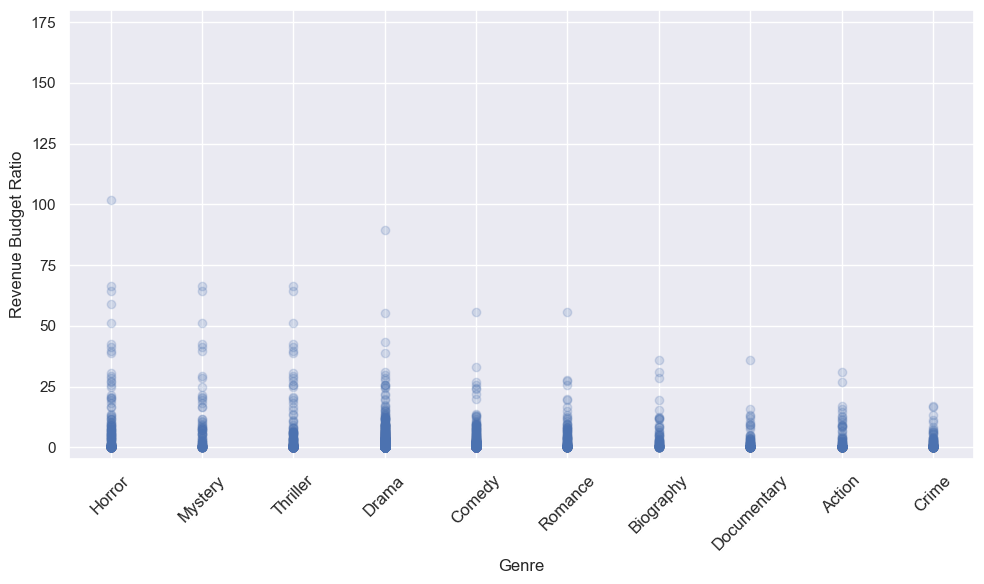

In [17]:

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(data=MergedExploded_df, x='Genres', y='RBR', alpha=0.2)
ax.set_ylim(top=180, bottom =-5)
ax.set_ylabel('Revenue Budget Ratio')
ax.set_xlabel('Genre')
ax.tick_params(axis='x', labelsize=12, labelrotation=45)

plt.tight_layout()

In [18]:
# Connecting to Persons Schema and Joining with Known For and Movie Basics Schemas

persons_query = """ 
    SELECT *
    FROM persons
    JOIN directors
        USING(person_id)
    JOIN movie_basics
        USING(movie_id)
"""

joined_df = pd.read_sql(persons_query, conn)

clean_column_headers(joined_df)
joined_df = pd.DataFrame(data=joined_df, columns=['Primary Name', 'Primary Title'])
joined_df.columns = joined_df.columns.str.replace('Primary Title', 'Movie')
joined_df.columns = joined_df.columns.str.replace('Primary Name', 'Name')
joined_df = joined_df.drop_duplicates(subset='Name')

# Creating Top Three Genres Dataframe
Merged_df.dropna(inplace=True)
Merged_df = Merged_df.merge(joined_df, on = 'Movie', how='left')
TopThreeGenres_df = Merged_df.loc[(Merged_df['Genres'].apply(lambda x: 'Horror' in x)) | (Merged_df['Genres'].apply(lambda x: 'Mystery' in x))
             | (Merged_df['Genres'].apply(lambda x: 'Thriller' in x))].reset_index(drop=True)
TopThreeGenres_df.dropna(inplace=True)

TopThreeGenres_df.groupby(by='Name').mean()['Revenue Budget Ratio'].sort_values(ascending=False)[:10]



/var/folders/9n/kzdbb24d6718p004k3bbjtr40000gn/T/ipykernel_11480/2050264355.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  TopThreeGenres_df.groupby(by='Name').mean()['Revenue Budget Ratio'].sort_values(ascending=False)[:10]


Name
Chris Lofing          416.564740
William Brent Bell    101.759490
Jordan Peele           51.073590
Bradley Parker         42.411721
John R. Leonetti       39.517372
Daniel Stamm           38.981056
James DeMonaco         30.422194
Holly Bell             29.242602
Yun Xie                27.179241
Tom Boyle              27.179241
Name: Revenue Budget Ratio, dtype: float64

In [19]:
TopThreeGenres_df['Name'].value_counts()

Padcha Ithi          2
Alicia Dwyer         2
Emilio Belmonte      2
Ric Roman Waugh      2
Sebastian Klinger    2
                    ..
Jordan Brown         1
Jonatan Burnett      1
Jerry Jameson        1
David Kabale         1
Scott Dow            1
Name: Name, Length: 360, dtype: int64